# Chapter 7. 토픽 모델링으로 주제 찾기

## 1. 토픽 모델링의 이해

1: https://mobile.newsis.com/view.html?ar_id=NISX20190918_0000772783#_enliple
2: https://cyram.tistory.com/309

### 1.1 LDA(Latent Dirichlet Allocation)



### 1.2 모형의 평가와 적절한 토픽 수의 결정


## 2. 사이킷런을 이용한 토픽 모델링

### 2.1 데이터 준비



In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

### 2.2 LDA 토픽 모델링 실행


1: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html <br>
2: Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.015 0.007 0.008 0.829 0.008 0.008 0.02  0.007 0.007 0.091]
#Sum of topic weights of documents: [0.082 0.082 0.094 0.109 0.114 0.138 0.086 0.071 0.072 0.152]
#shape of topic word distribution: (10, 2000)


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, article, sandvik, apple, university, kent, science, wrote, islam, frank
Topic #1: image, graphics, file, files, ftp, software, available, program, data, use
Topic #2: com, access, posting, net, digex, article, ibm, internet, like, pat
Topic #3: article, com, don't, keith, nntp, think, host, just, posting, sgi
Topic #4: key, clipper, chip, encryption, government, com, keys, law, escrow, use
Topic #5: scsi, university, nntp, host, thanks, posting, com, know, bit, bus
Topic #6: space, nasa, gov, launch, orbit, center, earth, shuttle, satellite, research
Topic #7: drive, disk, hard, com, controller, drives, dos, problem, tape, floppy
Topic #8: key, public, mail, faq, message, pgp, information, university, group, des
Topic #9: god, people, don't, jesus, just, think, say, believe, does, know



### 2.3 최적의 토픽 수 선택하기


n_components: 6, perplexity: 1052.061
n_components: 7, perplexity: 1055.910
n_components: 8, perplexity: 1027.856
n_components: 9, perplexity: 1018.301
n_components: 10, perplexity: 1024.421
n_components: 11, perplexity: 1035.376
n_components: 12, perplexity: 1031.050
n_components: 13, perplexity: 1039.640
n_components: 14, perplexity: 1038.313
n_components: 15, perplexity: 1043.554


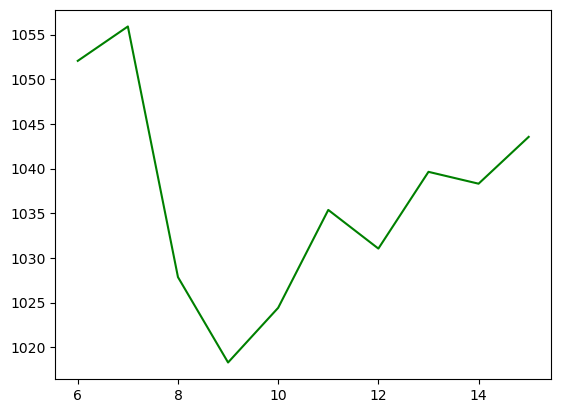

9

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=6, end=15)

In [6]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: graphics, image, mail, available, file, ftp, information, files, data, software
Topic #1: space, nasa, gov, orbit, earth, ___, center, launch, research, washington
Topic #2: com, keith, nntp, host, posting, morality, article, caltech, sgi, objective
Topic #3: com, article, jesus, know, god, just, posting, john, host, nntp
Topic #4: people, god, don't, does, think, say, believe, just, like, way
Topic #5: drive, scsi, com, card, disk, thanks, ide, controller, bus, hard
Topic #6: article, com, just, access, like, posting, nntp, host, space, net
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



## 3. Gensim을 이용한 토픽 모델링


### 3.1 Gensim 사용법과 시각화

1: https://radimrehurek.com/gensim/

In [7]:
#!pip install --upgrade gensim

In [8]:
# 필요한 library들을 import
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

1: https://radimrehurek.com/gensim/corpora/dictionary.html

In [9]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


1: https://radimrehurek.com/gensim/models/ldamodel.html 

In [10]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

CPU times: total: 5.59 s
Wall time: 8.31 s


In [11]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [12]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])

#topic distribution of the first document:  [(0, 0.7257719), (8, 0.26994798)]


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655430
5      0.065990  0.123619       2        1  14.522811
9      0.072133  0.092872       3        1  12.987431
7      0.138320  0.043608       4        1  11.020430
4     -0.021828  0.007494       5        1   9.298366
6      0.072783 -0.094709       6        1   9.118880
3      0.027375 -0.054949       7        1   8.494199
0     -0.040788 -0.129974       8        1   4.524040
2      0.005360 -0.091972       9        1   4.051827
1     -0.182145  0.063762      10        1   3.326586, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.444149  1672.570915  Topic10  -5.1558   0.1469
789          sci    53.262774   309.473888  Topic10  -5.3463   1.6436
602   university    56.862488  1487.219649  Topic10  -5.2810   0.1392
294         time    55.766934  1187.715484  Topic10  -5.3004   0.3446
315       better    54.192057   564.543605  Topic10  -5.3291   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

### 3.2 혼란도와 토픽 응집도를 이용한 최적값 선택

https://radimrehurek.com/gensim/models/coherencemodel.html

In [15]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


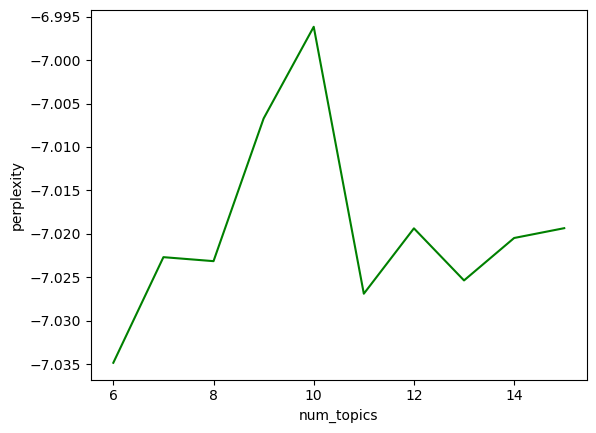

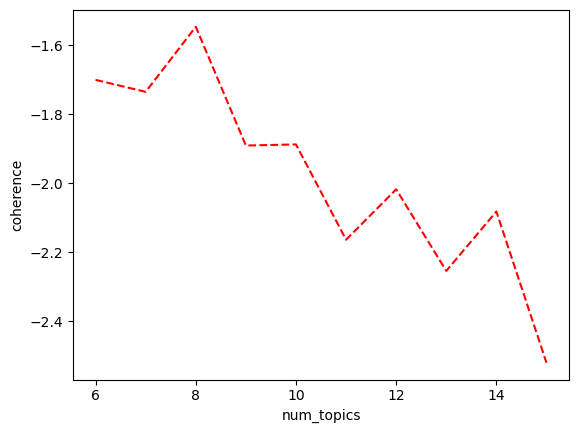

In [16]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

## 4. 토픽트렌드로 시간에 따른 주제의 변화 알아내기

1: https://github.com/akngs/petitions

In [18]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000) #적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

C:\Users\ParkSangun\anaconda3\envs\text\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(18077, 1000)


In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names_out(), 15)

CPU times: total: 484 ms
Wall time: 8.03 s
Topic #0: 사람, 생각, 피해자, 처벌, 사건, 병원, 가해자, 대통령, 국민, 나라, 자신, 환자, 정말, 대한민국, 가족
Topic #1: 북한, 한국, 우리, 대통령, 정부, 대한민국, 미국, 국민, 문재인, 일본, 국가, 문제, 생각, 우리나라, 나라
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 출산, 아빠, 결혼
Topic #3: 청소년, 불법, 보호, 폐지, 장애인, 조직, 이용, 생각, 사찰, 게임, 노인, 사람, 사회, 축구, 나이
Topic #4: 주택, 정부, 정책, 부동산, 서민, 아파트, 국민, 나라, 세금, 대통령, 사람, 지금, 서울, 투기, 집값
Topic #5: 일자리, 정부, 기업, 생각, 근무, 지원, 근로자, 임금, 최저임금, 정책, 시간, 사람, 고용, 대기업, 직원
Topic #6: 국민, 청원, 국회의원, 국회, 난민, 의원, 대통령, 청와대, 정치, 세금, 반대, 생각, 나라, 대한민국, 국가
Topic #7: 관리, 대한, 내용, 판결, 관련, 공사, 조사, 업무, 판사, 확인, 사실, 결과, 기관, 해당, 경우
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 국민, 방송, 의료, 소득, 건강, 가입, 국가, 보험료, 기초, 제도
Topic #10: 여성, 공무원, 사회, 생각, 남성, 남자, 대한민국, 의무, 사람, 여자, 행정, 군대, 나라, 국가, 문제
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 만행, 경찰서, 범죄자, 수사, 부정부패, 검찰, 살인마
Topic #12: 처벌, 차량, 사건, 사고, 경우, 기사, 피해, 대한, 피해자, 안전, 행위, 이명박, 청원, 택시, 관련
Topic #1

In [22]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.551813,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.041175,2017-08
4,0.000447,0.000447,0.000447,0.000447,2017-08


In [23]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.031564,0.015125,0.032138,0.026306,0.107615
2017-09,0.041628,0.025142,0.053777,0.020606,0.039820
2017-10,0.084683,0.053623,0.057386,0.031646,0.088069
2017-11,0.045303,0.040608,0.229142,0.040015,0.048151
2017-12,0.055756,0.026878,0.071888,0.048763,0.081157


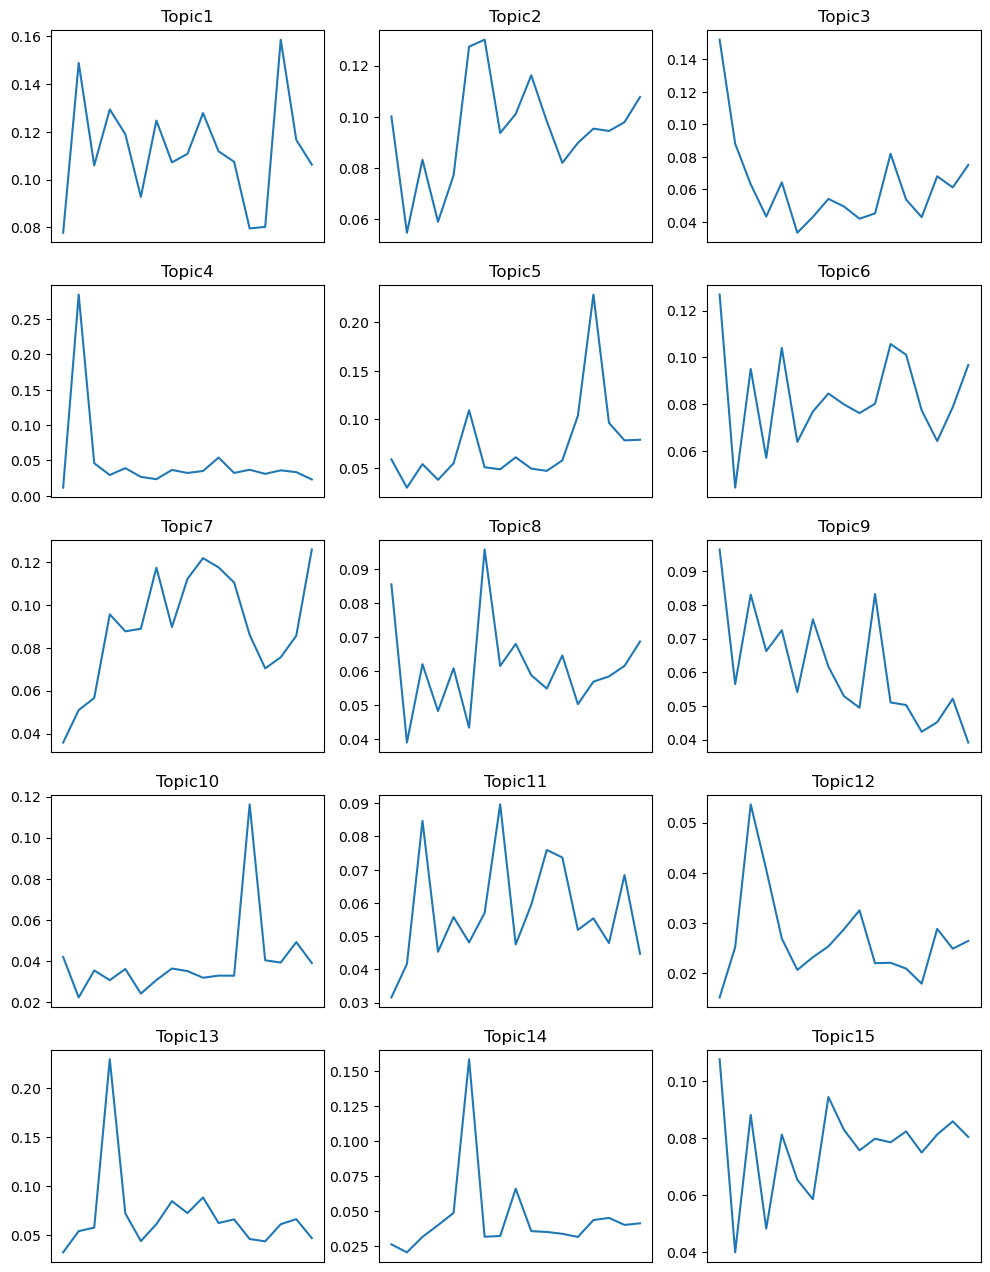

In [24]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()